The aim of this notebook is to show the user how to compute the anallytical expectation of dyadic motifs given the solution of the Directed Configuration Model.
Tools to define the statistical significance of the observed numerosity of dyadic motifs are provided.
Because Dyadic motifs are well defined on networks binary and directed, the analytical results presented here work only on `dcm` model.

# Dyads, or the unexpected value of 2-nodes motifs

## 1 Observed Dyads

FIrst let's give some context by defining what are dyadic motifs.
On a directed network $G(N, E)$, given two nodes $i,j \in E$ you can observe three disjoint possibilities:
- a __reciprocated dyad__: $(i,j), (j,i) \in E$, meaning a connection exists both from $i$ to $j$ and vice versa. We denote the total number of reciprocated dyads in the network as $L^{\leftrightarrow}$
$$
L^\leftrightarrow = \sum_{i\neq j}a_{ij}a_{ji}
$$
- non __reciprocated dyad__: $(i,j)\in E$ or $(j,i)\in E$, meaning only one of the two possible links exists. We denote the total number of non reciprocated dyads as $L^{\rightarrow}$
$$
L^\rightarrow = \sum_{i\neq j}a_{ij}(1-a_{ji})
$$
- __empty dyad__$(i,j), (j,i) \notin E$, meaning no link exists between the two nodes.
    The total number of empty dyads is denoted by $L^{\nleftrightarrow}$
$$
L^\nleftrightarrow = \sum_{i\neq j}(1-a_{ij})(1-a_{ji})
$$


Now, we load the module `NEMtropy.matrix_generator` in order to work with networks on python in general and, in the specific, in order to load a graph to start experimenting on:

In [1]:
import NEMtropy as nem
from NEMtropy.matrix_generator import random_binary_matrix_generator_custom_density

# 
A = random_binary_matrix_generator_custom_density(5,
                                                  0.6,
                                                  sym=False,
                                                  seed=100)

print(A)

[[0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


Now, the first interesting thing we can do is to compute the numerosity of the three types of dyads we described before. 

`NEMtropy` provides us functions to achieve this: functions related to computing measures directly on a given networks are contained in `network_functions`:
- `NEMtropy.network_functions.count_2motif_2()`
- `NEMtropy.network_functions.count_2motif_1()`
- `NEMtropy.network_functions.count_2motif_0()`

Let's dig in the functions names here:
- `count` stands for counting the motifs in the network
- `_2motif` indicates the cathegory of motifs we are considering, classified by the number of nodes: in this case it means motifs of 2 nodes.
- the last number indicates the 2-nodes motif type:
    - `_0` means empty dyads
    - `_1` means non-reciprocated(singles) dyads
    - `_2` means fully reciprocated dyads

In [2]:
from NEMtropy.network_functions import count_2motif_2, count_2motif_1, count_2motif_0

full_dyads = count_2motif_2(A)
print(f' number of reciprocated dyads = {full_dyads}')
single_dyads = count_2motif_1(A)
print(f' number of non reciprocated dyads = {single_dyads}')
zeros_dyads = count_2motif_0(A)
print(f' number of empty dyads = {zeros_dyads}')

 number of reciprocated dyads = 8
 number of non reciprocated dyads = 5
 number of empty dyads = 2


# 2 Expected dyads

Now let's solve the `dcm` problem associated to `A`

In [3]:
# load adjacency matrix A as a Directed Graph object in NEMtropy
G = nem.DirectedGraph(A)

# solve the dcm problem
G.solve_tool(model="dcm_exp",
                method="newton",
                initial_guess="random")


/usr/lib/python3/dist-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/home/user/vallarano/NEMtropy/src/NEMtropy/models_functions.py:3181: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
/home/user/vallarano/NEMtropy/src/NEMtropy/models_functions.py:3182: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
/usr/lib/python3/dist-packages/numba/core/utils.py:451: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",



solution error = 2.5290880500961066e-12


Nice! the solution error is close to zero, meaning we have a good solution.

### 2.1 Analytical z-score

NEMtropy class DirectedGraph offers us function `motifs_2_zscore()` to compute the analytical z-score for each of the three dyads categories. 
Remind that the z-score of a r.v. $X$ is defined as $z[X]$:

$$
z[X] = \frac{X^*[A] - \mu[x]}{\sigma[X]}
$$

where:
- $X^*[A]$ is the value of $X$ computed on the actual adjacency matrix $A$
- $\mu[X]$ is $X$ expected value
- $\sigma[X]$ is $X$ standard deviation

In [4]:
z_score_analytical = G.zscore_2motifs()
print(z_score_analytical)

{'0': 0.12109489188171507, '1': -0.13523627835427715, '2': 0.07047100104601167}


### 2.2 Empirical z-score

Of course we can use the sampling function in order to compute the dyads z-score empirically. The results obtained should be close to the analytical results as the numerosity of the sample increases.

First we sample 100 graphs from the DCM ensemble enerated by the solution:

In [5]:
# We generate an ensemble copy
n = 1000
G.ensemble_sampler(n, cpu_n=2, output_dir="sample/")

now, for each graph in the sampling we compute empirical expected value and standard deviation of the dyads variables.

To compute the dyads we resort to the network functions we saw in the first paragraph

In [8]:
import networkx as nx
import numpy as np

# memory pre-allocation
emp_dyads = np.zeros(n)
emp_singles = np.zeros(n)
emp_zeros = np.zeros(n)

for i in range(n):
    # Read the graph as an edgelist
    edgelist_ens = np.loadtxt(f"sample/{i}.txt")
    # read the graph in networkx 
    graph = nx.DiGraph()
    graph.add_edges_from(edgelist_ens.astype(int))
    # create adjacency matrix as numpy array
    a = nx.to_numpy_array(graph)
    # compute dyads numerosity
    emp_dyads[i] = count_2motif_2(a)
    emp_singles[i] = count_2motif_1(a)
    emp_zeros[i] = count_2motif_0(a)

For each dyad category we initialize a numpy array as long as the sample numerosity.
We are now able to compute the z-score for each dyad category

In [10]:
z_score = {}
emp_mu = np.mean(emp_dyads)
emp_std = np.std(emp_dyads)
z_score['dyads'] = (count_2motif_2(A) - emp_mu)/emp_std
emp_mu = np.mean(emp_singles)
emp_std = np.std(emp_singles)
z_score['singles'] = (count_2motif_1(A) - emp_mu)/emp_std
emp_mu = np.mean(emp_zeros)
emp_std = np.std(emp_zeros)
z_score['zeros'] = (count_2motif_0(A) - emp_mu)/emp_std

print(z_score)

{'dyads': 0.11792134237568584, 'singles': -0.15740096917037907, 'zeros': 0.0818382050299025}


As you can observe, while the empirical results is not perfectly coincident with the analytical one, they are close enough to be considered satisfactory. 

**But the inquisitive minds would ask themselve: am I sure is it close enough? And is it converging?**

Well, let's see.

### 3.3 Empirical sequence convergence to analytical value

In [12]:
# memory pre-allocation
sample_numerosity = list(range(10,1010,50))
z_score_empirical ={
    '2': [],
    '1': [],
    '0': []
}
for n in sample_numerosity: 
    emp_dyads = np.zeros(n)
    emp_singles = np.zeros(n)
    emp_zeros = np.zeros(n)

    for i in range(n):
        # Read the graph as an edgelist
        edgelist_ens = np.loadtxt(f"sample/{i}.txt")
        # read the graph in networkx 
        graph = nx.DiGraph()
        graph.add_edges_from(edgelist_ens.astype(int))
        # create adjacency matrix as numpy array
        a = nx.to_numpy_array(graph)
        # compute dyads numerosity
        emp_dyads[i] = count_2motif_2(a)
        emp_singles[i] = count_2motif_1(a)
        emp_zeros[i] = count_2motif_0(a)

    emp_mu = np.mean(emp_dyads)
    emp_std = np.std(emp_dyads)
    z_score_empirical['2'].append((count_2motif_2(A) - emp_mu)/emp_std)
    emp_mu = np.mean(emp_singles)
    emp_std = np.std(emp_singles)
    z_score_empirical['1'].append((count_2motif_1(A) - emp_mu)/emp_std)
    emp_mu = np.mean(emp_zeros)
    emp_std = np.std(emp_zeros)
    z_score_empirical['0'].append((count_2motif_0(A) - emp_mu)/emp_std)

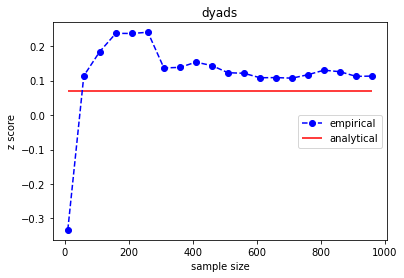

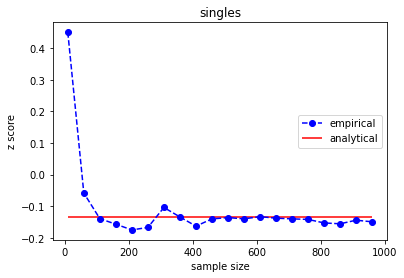

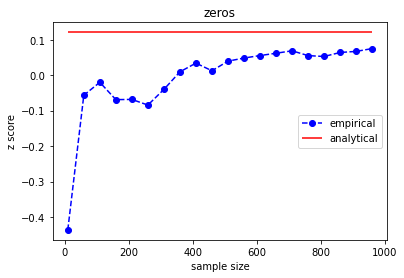

In [13]:
import matplotlib.pyplot as plt

data_map = {
    '0': 'zeros',
    '1': 'singles',
    '2': 'dyads'
}

for data in ['2', '1', '0']:
    plt.figure()

    plt.plot(
        sample_numerosity,
        z_score_empirical[data],
        color = 'blue',
        marker='o', 
        linestyle='dashed',
        label = 'empirical'
        )

    plt.hlines(
        y = z_score_analytical[data],
        xmin = sample_numerosity[0],
        xmax = sample_numerosity[-1],
        color = 'red',
        label = 'analytical'
    )

    plt.xlabel('sample size')
    plt.ylabel('z score')
    plt.legend(loc='center right')
    plt.title(f'{data_map[data]}')
    plt.show()

Well these three figures should convince even the skeptical soul that we are onto something here: the empirical sequence is converging to the analytical prediction.

# Never Two Without Three: 3-nodes motifs

As often happens, increasing the number of nodes is equivalent to icnrease the complexity of the problem.
